In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

In [ ]:
%cd /content/gdrive/My Drive/dacon/review/

In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [22]:
from konlpy.tag import Mecab, Kkma

In [23]:
mc = Mecab()
kk = Kkma()

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train['document'] = train['document'].str.replace('ㅡㅡ', '화남')
test['document'] = test['document'].str.replace('ㅡㅡ', '화남')

In [8]:
train['doc_length'] = train.document.apply(len)

In [10]:
train.doc_length.min()

16

In [15]:
mc.pos(train.document[0])

[('영상', 'NNG'),
 ('이나', 'JC'),
 ('음악', 'NNG'),
 ('이', 'JKS'),
 ('이쁘', 'VA'),
 ('다', 'EC'),
 ('해도', 'VV+EC'),
 ('미', 'NNG'),
 ('화', 'XSN'),
 ('시킨', 'XSV+ETM'),
 ('불륜', 'NNG'),
 ('일', 'VCP+ETM'),
 ('뿐', 'NNB')]

In [16]:
mc.pos(test.document[0])

[('시간', 'NNG'),
 ('때우', 'VV'),
 ('기', 'ETN'),
 ('좋', 'VA'),
 ('은', 'ETM'),
 ('영화', 'NNG'),
 ('지루함', 'NNP')]

In [17]:
mc.pos(test.document[10])

[('나가토', 'NNP'),
 ('의', 'JKG'),
 ('나가토', 'NNP'),
 ('에', 'JKB'),
 ('의한', 'VV+ETM'),
 ('나가토', 'NNP'),
 ('를', 'JKO'),
 ('위한', 'VV+ETM')]

In [26]:
mc.pos(test.document[500])

[('하', 'IC'),
 ('.', 'SF'),
 ('..', 'SY'),
 ('이렇게', 'MAG'),
 ('재밌', 'VA'),
 ('는', 'ETM'),
 ('영화', 'NNG'),
 ('를', 'JKO'),
 ('이', 'MM'),
 ('따구', 'NNG'),
 ('로', 'JKB'),
 ('밖에', 'JX'),
 ('못살', 'VV+ETM'),
 ('이', 'VCP'),
 ('다니', 'EF'),
 ('.', 'SF'),
 ('.', 'SY'),
 ('참', 'IC'),
 ('감독', 'NNG'),
 ('이', 'JKS'),
 ('호구', 'NNG'),
 ('네', 'XSA+EC')]

In [27]:
mc.pos(test.document[2500])

[('잊', 'VV'),
 ('을', 'ETM'),
 ('수', 'NNB'),
 ('없', 'VA'),
 ('는', 'ETM'),
 ('조커', 'NNG'),
 ('와', 'JC'),
 ('배트맨', 'NNP'),
 ('.', 'SF'),
 ('.', 'SY'),
 ('킴', 'NNP'),
 ('누나', 'NNG'),
 ('의', 'JKG'),
 ('미모', 'NNG'),
 ('도', 'JX'),
 ('.', 'SF'),
 ('..', 'SY')]

In [50]:
def get_pos_corpus_cnt(data) :
  pos_corpus = []
  cnt = []
  for doc in data.document :
    doc_pos = mc.pos(doc)
    pos_list = []
    for value in doc_pos :
      if value[1].startswith('N') or value[1].startswith('VA') or value[1].startswith('VV') or value[1].startswith('MA') :
        pos_list.append(value[0])
        cnt.append(value[0])
      else :
        pass
    pos_corpus.append(pos_list)
  
  return pos_corpus, cnt

In [51]:
tr_pos, tr_cnt = get_pos_corpus_cnt(train)
te_pos, te_cnt = get_pos_corpus_cnt(test)

In [31]:
from collections import Counter

In [47]:
tr_cnt = Counter(cnt)

In [52]:
train['pos_corpus'] = tr_pos
test['pos_corpus'] = te_pos

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [144]:
X_train = train['pos_corpus']
X_test = test['pos_corpus']

y_train = np.array(train.label)

In [145]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [146]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6236
등장 빈도가 2번 이하인 희귀 단어의 수: 4576
단어 집합에서 희귀 단어의 비율: 73.38037203335472
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.156613007842445


In [147]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 5이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1661


In [148]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [149]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [150]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

4983
4983


In [84]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

train data의 최대 길이 : 25
train data의 평균 길이 : 5.707003812964078


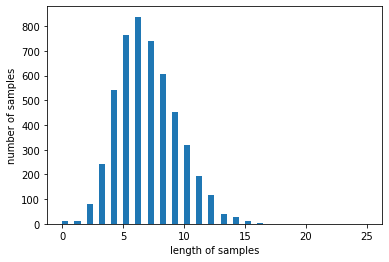

In [151]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  15
test data의 평균 길이 :  5.4646


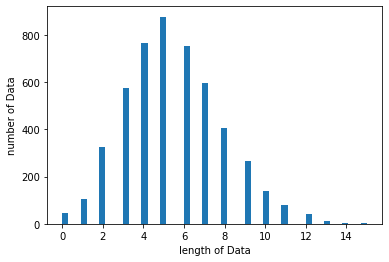

In [152]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [153]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [154]:
max_len = 25
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 100.0


In [155]:
X = pad_sequences(del_X_train, maxlen = max_len)
target = pad_sequences(token_X_test, maxlen = max_len)

In [156]:
y = del_y_train.copy()

In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [158]:
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

In [159]:
model1_pred = np.zeros(target.shape[0])
for n, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
  tr_x, tr_y = X[tr_idx], y[tr_idx]
  val_x, val_y = X[val_idx], y[val_idx]

  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_len))
  model.add(Conv1D(64, 5, activation = 'relu', padding = 'same', kernel_regularizer = l2(0.01)))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(optimizer = Adam(lr = .0003), loss = 'binary_crossentropy', metrics = ['acc'])
  reLR = ReduceLROnPlateau(patience = 5, verbose = 1, factor = .9)
  es = EarlyStopping(monitor = 'val_acc', mode = 'max', verbose = 1, patience = 15)
  mc = ModelCheckpoint(filepath = '1st_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True, restore_best_weights = True)

  history = model.fit(tr_x, tr_y, epochs = 300, batch_size= 32, shuffle = True, validation_split = 0.2, verbose = 1, callbacks = [es, mc, reLR])
  best = load_model('1st_model.h5')
  val_pred = [v[0] for v in best.predict(val_x)]
  val_cls = [1 if v >= 0.5 else 0 for v in val_pred]
  val_acc = accuracy_score(val_y, val_cls)
  print(f'{n + 1}Fold ACC = {val_acc}\n')

  fold_pred = [v[0] / 10 for v in best.predict(target)]
  model1_pred += fold_pred

Epoch 1/300
113/113 [==============================] - ETA: 0s - loss: 1.1786 - acc: 0.5999
Epoch 00001: val_acc improved from -inf to 0.56856, saving model to 1st_model.h5
113/113 [==============================] - 1s 7ms/step - loss: 1.1786 - acc: 0.5999 - val_loss: 0.9174 - val_acc: 0.5686 - lr: 3.0000e-04
Epoch 2/300
107/113 [===========================>..] - ETA: 0s - loss: 0.7983 - acc: 0.7585
Epoch 00002: val_acc improved from 0.56856 to 0.78818, saving model to 1st_model.h5
113/113 [==============================] - 1s 5ms/step - loss: 0.7942 - acc: 0.7614 - val_loss: 0.7098 - val_acc: 0.7882 - lr: 3.0000e-04
Epoch 3/300
106/113 [===========================>..] - ETA: 0s - loss: 0.6235 - acc: 0.8600
Epoch 00003: val_acc improved from 0.78818 to 0.81048, saving model to 1st_model.h5
113/113 [==============================] - 1s 5ms/step - loss: 0.6208 - acc: 0.8564 - val_loss: 0.5702 - val_acc: 0.8105 - lr: 3.0000e-04
Epoch 4/300
105/113 [==========================>...] - ETA: 0

In [160]:
final_pred = [1 if p >= 0.5 else 0 for p in model1_pred]

In [161]:
submission = pd.read_csv("sample_submission.csv")

In [162]:
submission['label'] = final_pred

In [163]:
submission.label.value_counts()

0    2602
1    2398
Name: label, dtype: int64

In [164]:
submission.to_csv("dl_1st.csv", index = False)